# Time series prediction using LSTM

### Goals: Correct use of TensorFlow library to predict air quality data using multivariate time series data

Dataset used: https://archive.ics.uci.edu/ml/datasets/Air+Quality

Steps:
- EDA
- Handling null values
- preparing sequences
- preparing data for training and testing
- plotting the model's performance on test data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale = 1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 16,10

In [2]:
import pandas as pd

raw = pd.read_csv('AirQualityUCI.csv', delimiter = ';')
raw.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


Looking at the data, we will need to create an index column out of the data+time columns. We also need to scale the data, but before that we need to see the counts of the NaN (-200 values according to the data description) and declare the target variable.

### Attribute Information:

- Date (DD/MM/YYYY)
- Time (HH.MM.SS)
- True hourly averaged concentration CO in mg/m^3 (reference analyzer)
- PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
- True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
- True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
- PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
- True hourly averaged NOx concentration in ppb (reference analyzer)
- PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
- True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
- PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
- PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
- Temperature in Â°C
- Relative Humidity (%)
- AH Absolute Humidity

In [3]:
raw[raw.eq(-200).any(1)]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
9,11/03/2004,03.00.00,"0,6",1010.0,19.0,"1,7",561.0,-200.0,1705.0,-200.0,1235.0,501.0,"10,3","60,2","0,7517",NaN,NaN
33,12/03/2004,03.00.00,"0,8",889.0,21.0,"1,9",574.0,-200.0,1680.0,-200.0,1187.0,512.0,"7,0","62,3","0,6261",NaN,NaN
39,12/03/2004,09.00.00,-200,1545.0,-200.0,"22,1",1353.0,-200.0,767.0,-200.0,2058.0,1588.0,"9,2","56,2","0,6561",NaN,NaN
57,13/03/2004,03.00.00,"1,7",1172.0,46.0,"5,4",783.0,-200.0,1179.0,-200.0,1380.0,996.0,"7,8","67,5","0,7173",NaN,NaN
81,14/03/2004,03.00.00,"2,4",1344.0,132.0,"9,7",968.0,-200.0,921.0,-200.0,1620.0,1278.0,"11,6","63,4","0,8674",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,"3,1",1314.0,-200.0,"13,5",1101.0,472.0,539.0,190.0,1374.0,1729.0,"21,9","29,3","0,7568",NaN,NaN
9353,04/04/2005,11.00.00,"2,4",1163.0,-200.0,"11,4",1027.0,353.0,604.0,179.0,1264.0,1269.0,"24,3","23,7","0,7119",NaN,NaN
9354,04/04/2005,12.00.00,"2,4",1142.0,-200.0,"12,4",1063.0,293.0,603.0,175.0,1241.0,1092.0,"26,9","18,3","0,6406",NaN,NaN
9355,04/04/2005,13.00.00,"2,1",1003.0,-200.0,"9,5",961.0,235.0,702.0,156.0,1041.0,770.0,"28,3","13,5","0,5139",NaN,NaN


In [4]:
#so apparently almost all the rows have a -200 value, we need to approach this column after column
#first of all, do we actually need the time column? apparently all the values are there, even though the time value is missing

raw.isna().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [5]:
raw.drop(columns=['Unnamed: 15','Unnamed: 16'])

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#are the NaNs all at the end of the dataset?

nans = raw.iloc[-114:,:]
nans.isna().sum()

Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
Unnamed: 15      114
Unnamed: 16      114
dtype: int64

In [7]:
cp = raw.copy()
raw = raw.iloc[:-114,:]
raw.isna().sum()

Date                0
Time                0
CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)            0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
Unnamed: 15      9357
Unnamed: 16      9357
dtype: int64

In [8]:
#okay, no NaNs, now let's see the -200 values
raw['Time'].where(raw['Time']==-200).sum()

0

In [9]:
raw['CO(GT)'].value_counts()

-200    1592
1,4      279
1,6      275
1,5      273
1,1      262
        ... 
9,9        1
9,5        1
7,6        1
8,5        1
7          1
Name: CO(GT), Length: 104, dtype: int64

In [10]:
#okay, the second column has 1592 empty entries. Given that the data is sequential, we can't really use a mean of this column,
#that would make no sense with regard to the time series analysis
# ... the idea is add an average of the two closest relevant values, but how to code that?

experiment = raw['CO(GT)']

I was having trouble with replacing the NaNs with pandas replace method, so I saved the csv and loaded again. This can't be done in the beginning, since there are full NaN rows which need to be discovered.

In [11]:
#raw.to_csv('semi_prep.csv')

In [12]:
raw = pd.read_csv('semi_prep.csv', na_values=(-200))
raw.head()

,Unnamed: 0,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [13]:
raw.isna().sum()

Unnamed: 0          0
Date                0
Time                0
CO(GT)           1592
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Unnamed: 15      9357
Unnamed: 16      9357
dtype: int64

In [14]:
#and of course the unnamed columns were not removed as I did not assign it back (:
raw = raw.drop(columns=['Unnamed: 0','Unnamed: 15','Unnamed: 16'])

In [15]:
raw.isna().sum()

Date                0
Time                0
CO(GT)           1592
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [16]:
#let's deal with the NaNs at LAST
raw['CO(GT)'].isna().sum()

1592

In [17]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7765 non-null   object 
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   object 
 13  RH             8991 non-null   object 
 14  AH             8991 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [18]:
#alright, this is why the replace nor interpolate wouldn't work on the data. We need to have all the columns as float64
#BUT there are commas as separators, so we need to handle that the old school way first
raw1 = raw.copy()

In [26]:
cols_to_fix = ['CO(GT)','C6H6(GT)','T','RH','AH']
raw[cols_to_fix] = raw[cols_to_fix].astype(str) #convert to strings
raw[cols_to_fix] = raw[cols_to_fix].replace({',':'.'}, regex=True) #replace the string elements
raw[cols_to_fix] = raw[cols_to_fix].astype(np.float64) #cast as float64, now interpolate should work

In [27]:
raw.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [29]:
raw.info() #sehr gut

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7765 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [31]:
#the idea is using linear interpolation, but is it alright to use it on the entire dataset? Let's try a single column first
experiment = raw['CO(GT)'].copy()

In [41]:
experiment.isna().sum()

1592

In [48]:
c = experiment[experiment.isnull()].index.tolist()

In [ ]:
len(c) #got it right

The problem is that the data missing are large chunks of missing values, maybe the sensors were not working properly for some time, linear interpolation does not seem like the best idea for this case, let's see what happens

In [50]:
experiment1 = experiment.interpolate()
print(experiment1.mean(),experiment.mean())

0.18107833707384854 -0.21632968448164816


In [53]:
#what the fuck there are still -200s??

experiment[experiment==-200].index.tolist()

[7331,
 7332,
 7545,
 7546,
 7547,
 7548,
 7553,
 7554,
 7630,
 7631,
 7639,
 7640,
 7641,
 7642,
 7643,
 7644,
 7645,
 7646,
 7647,
 7648,
 7649,
 7650,
 7651,
 7652,
 7653,
 7654,
 7655,
 7656,
 7657,
 7658,
 7659,
 7660,
 7661,
 7662,
 7663,
 7665,
 7666,
 7684,
 7685,
 7686,
 7687,
 7688,
 7689,
 7690,
 7691,
 7692,
 7693,
 7709,
 7710,
 7711,
 7712,
 7713,
 7714,
 7715,
 7716,
 7717,
 7737,
 7738,
 7810,
 7839,
 7906,
 7978,
 8050,
 8122,
 8194,
 8266,
 8338,
 8410,
 8482,
 8554,
 8626,
 8698,
 8770,
 8794,
 8795,
 8796,
 8797,
 8817,
 8818,
 8819,
 8820,
 8821,
 8822,
 8842,
 8914,
 8986,
 9058,
 9130,
 9202,
 9274,
 9346]

In [54]:
raw = raw.replace({-200:np.nan})

In [55]:
experiment = raw['CO(GT)'].copy()
experiment[experiment==-200].index.tolist()

[]

In [56]:
raw.isna().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [57]:
#interesting, idk what's going on. let's compare it now
experiment1 = experiment.interpolate()
print(experiment.mean(),experiment1.mean())

2.1527495439145166 2.1306027572940045


In [58]:
# the mean does not seem to be totally different, let's just rely on the algorithm and the fact that maybe it will train well 
#on this data, probably not.

raw1 = raw.copy()

In [59]:
raw = raw.interpolate()

In [60]:
raw.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

array([[<AxesSubplot:xlabel='CO(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='PT08.S1(CO)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='NMHC(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='PT08.S2(NMHC)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='PT08.S3(NOx)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='NO2(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='PT08.S4(NO2)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='PT08.S5(O3)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='T', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='RH', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='AH', ylabel='CO(GT)'>],
       [<AxesSubplot:xlabel='CO(GT)', ylabel='PT08.S1(CO)'>,
        <AxesSubplot:xlabel='PT08.S1(CO)', ylabel='PT08.S1(CO)'>,
        <AxesSubplot:xlabel='NMHC(GT)', ylabel='PT08.S1(CO)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='PT08.S1(CO)

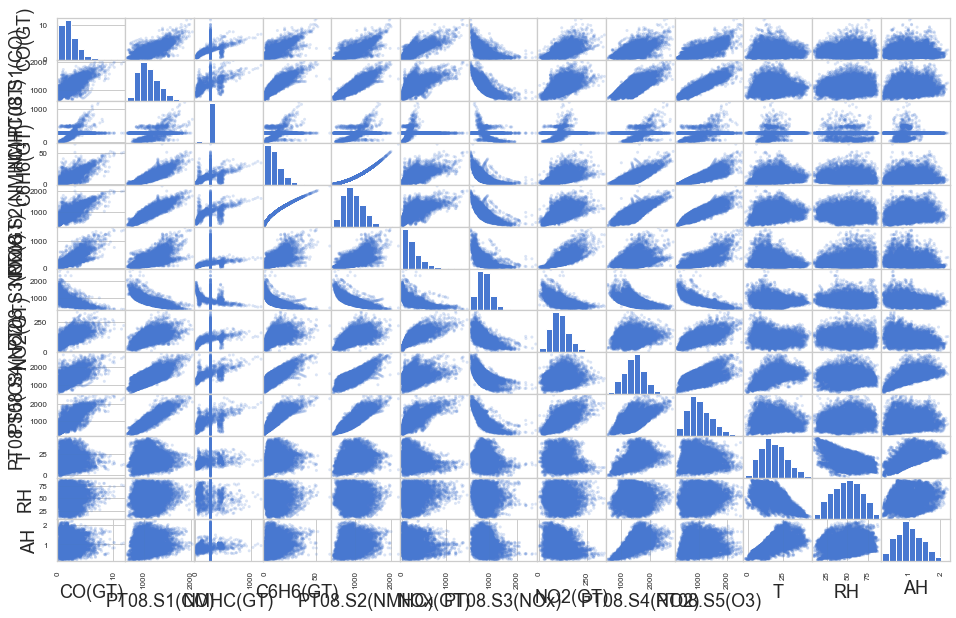

In [63]:
pd.plotting.scatter_matrix(raw, alpha=0.2)

Some of the distributions are not normal and maybe we should think about implementing some transformation? Log transform?

array([[<AxesSubplot:xlabel='CO(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='CO(GT)'>],
       [<AxesSubplot:xlabel='CO(GT)', ylabel='C6H6(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='C6H6(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='C6H6(GT)'>],
       [<AxesSubplot:xlabel='CO(GT)', ylabel='NOx(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='NOx(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='NOx(GT)'>]], dtype=object)

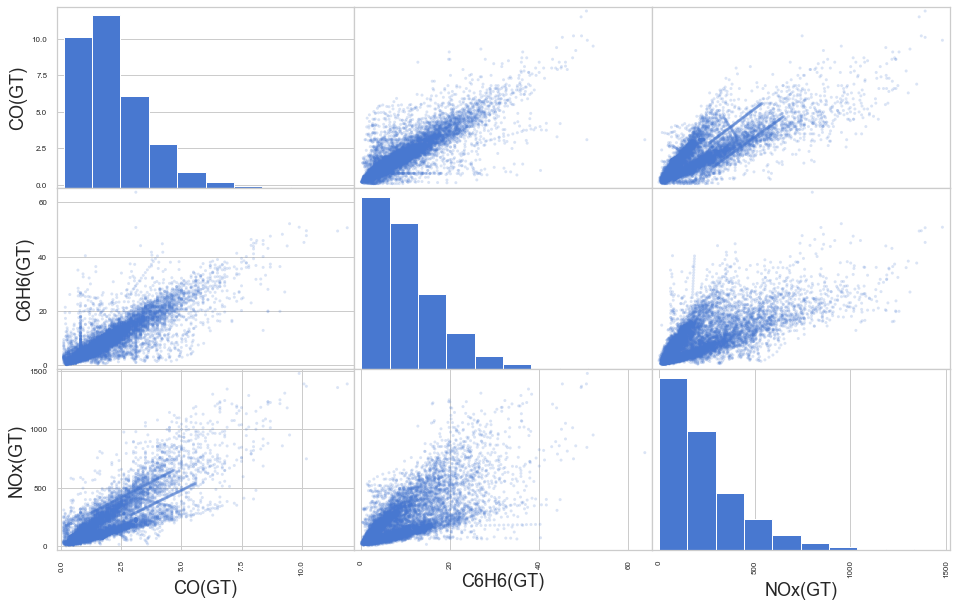

In [65]:
cols_to_trans = ['CO(GT)','C6H6(GT)','NOx(GT)']
trans = raw[cols_to_trans]
pd.plotting.scatter_matrix(trans, alpha=0.2)

array([[<AxesSubplot:xlabel='CO(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='CO(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='CO(GT)'>],
       [<AxesSubplot:xlabel='CO(GT)', ylabel='C6H6(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='C6H6(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='C6H6(GT)'>],
       [<AxesSubplot:xlabel='CO(GT)', ylabel='NOx(GT)'>,
        <AxesSubplot:xlabel='C6H6(GT)', ylabel='NOx(GT)'>,
        <AxesSubplot:xlabel='NOx(GT)', ylabel='NOx(GT)'>]], dtype=object)

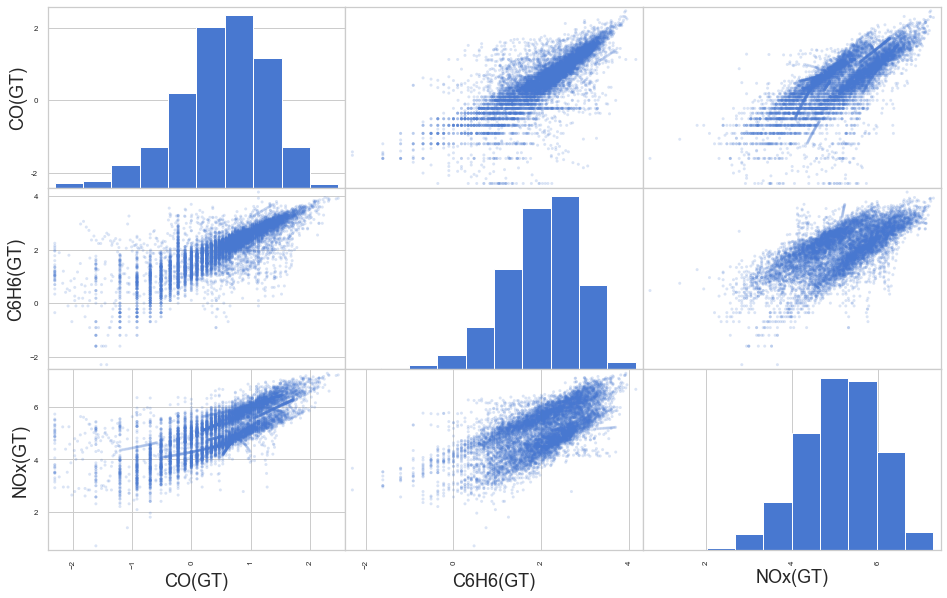

In [66]:
trans = np.log(trans)
pd.plotting.scatter_matrix(trans, alpha = 0.2)

In [67]:
#well, i don't see why not, theoretically it is not completely wrong
raw[cols_to_trans] = np.log(raw[cols_to_trans])

In [68]:
raw.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.955511,1360.0,150.0,2.476538,1046.0,5.111988,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,0.693147,1292.0,112.0,2.240710,955.0,4.634729,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,0.788457,1402.0,88.0,2.197225,939.0,4.875197,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,0.788457,1376.0,80.0,2.219203,948.0,5.147494,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,0.470004,1272.0,51.0,1.871802,836.0,4.875197,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Now the data is moreless preprocessed, I will save it as a new file and continue with modelling in another notebook.

In [69]:
raw.to_csv('data_preprocessed.csv', index=False)